In [1]:
!pip install medmnist
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d19452e8beb721f840cb1ded28911dc4911dbccfe619c3f365747472e058da87
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
  Attempting uninstall: nvidia-nvjitlink-c

In [2]:
!pip install torchmetrics

In [3]:
import medmnist
from medmnist import INFO
import torch
from torchvision import transforms
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [4]:
# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_data = DataClass(split='train', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)

100%|██████████| 206M/206M [00:34<00:00, 5.88MB/s]


In [5]:
# check data properties
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}")
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[0.7255, 0.7176, 0.7255,  ..., 0.7255, 0.7176, 0.7333],
         [0.7098, 0.7255, 0.7176,  ..., 0.5451, 0.5059, 0.4902],
         [0.7255, 0.7255, 0.7176,  ..., 0.6314, 0.6235, 0.6392],
         ...,
         [0.7098, 0.7020, 0.7333,  ..., 0.7333, 0.7255, 0.7333],
         [0.6706, 0.7020, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
         [0.6863, 0.7255, 0.7333,  ..., 0.7255, 0.7333, 0.7412]],

        [[0.6314, 0.6235, 0.6235,  ..., 0.6314, 0.6235, 0.6314],
         [0.6157, 0.6235, 0.6157,  ..., 0.3882, 0.3490, 0.3176],
         [0.6314, 0.6235, 0.6078,  ..., 0.4980, 0.5059, 0.5216],
         ...,
         [0.6078, 0.5765, 0.6314,  ..., 0.6314, 0.6314, 0.6392],
         [0.5059, 0.5686, 0.6314,  ..., 0.6314, 0.6392, 0.6314],
         [0.5294, 0.6235, 0.6314,  ..., 0.6314, 0.6314, 0.6392]],

        [[0.7804, 0.7804, 0.7804,  ..., 0.7804, 0.7804, 0.7804],
         [0.7725, 0.7725, 0.7725,  ..., 0.5843, 0.5451, 0.5294],
         [0.7725, 0.7725, 0.7647,  ..., 0.6706, 0.

In [6]:
# Number of image channels
n_channels = info['n_channels']
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info['label'])
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = info['label']
print(f"class names: {class_names}")

number of channels: 3
number of classes: 9
class names: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


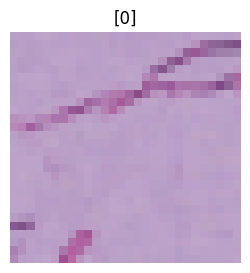

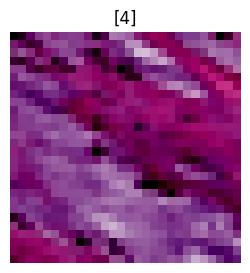

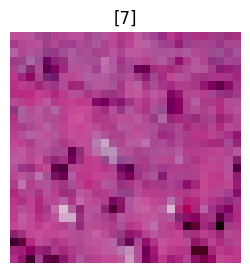

In [7]:
for i in range(3):
    img = train_data[i][0]
    label = train_data[i][1]
    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False);

In [8]:
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from skimage.exposure import equalize_hist
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix

# Preprocess: Flatten and normalize the images
def preprocess_images(data):
    x_data = []
    for img, label in data:
        img = img.numpy().flatten()  # Flatten and convert to numpy array
        x_data.append(img)
    return np.array(x_data)

# Preprocess the training and test data
x_train = preprocess_images(train_data)
y_train = np.array([label for _, label in train_data])
x_test = preprocess_images(test_data)
y_test = np.array([label for _, label in test_data])

# Ensure y_train and y_test are 1D arrays
y_train = y_train.ravel()  # Flatten the target to 1D array
y_test = y_test.ravel()    # Flatten the target to 1D array

x_train = x_train / 255.0
x_test = x_test / 255.0

# Feature Engineering: Add additional statistical features (mean, variance)
means_train = np.mean(x_train, axis=1)
variances_train = np.var(x_train, axis=1)
x_train_with_stats = np.column_stack((x_train, means_train, variances_train))

means_test = np.mean(x_test, axis=1)
variances_test = np.var(x_test, axis=1)
x_test_with_stats = np.column_stack((x_test, means_test, variances_test))

# Feature Selection: Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Reduce to 100 components (tune this value as needed)
x_train_pca = pca.fit_transform(x_train_with_stats)
x_test_pca = pca.transform(x_test_with_stats)

# Feature Selection: Select top 50 features using SelectKBest with ANOVA F-test (f_classif)
selector = SelectKBest(f_classif, k=50)
x_train_selected = selector.fit_transform(x_train_pca, y_train)
x_test_selected = selector.transform(x_test_pca)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
⌾ Best params: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 300, 'max_leaf_nodes': 31}

=== HistGradientBoosting (GridSearch) – Report ===
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1338
           1       0.76      1.00      0.86       847
           2       0.31      0.62      0.42       339
           3       0.77      0.53      0.63       634
           4       0.88      0.55      0.68      1035
           5       0.50      0.47      0.49       592
           6       0.49      0.42      0.45       741
           7       0.55      0.41      0.47       421
           8       0.60      0.72      0.65      1233

    accuracy                           0.67      7180
   macro avg       0.64      0.62      0.62      7180
weighted avg       0.69      0.67      0.67      7180



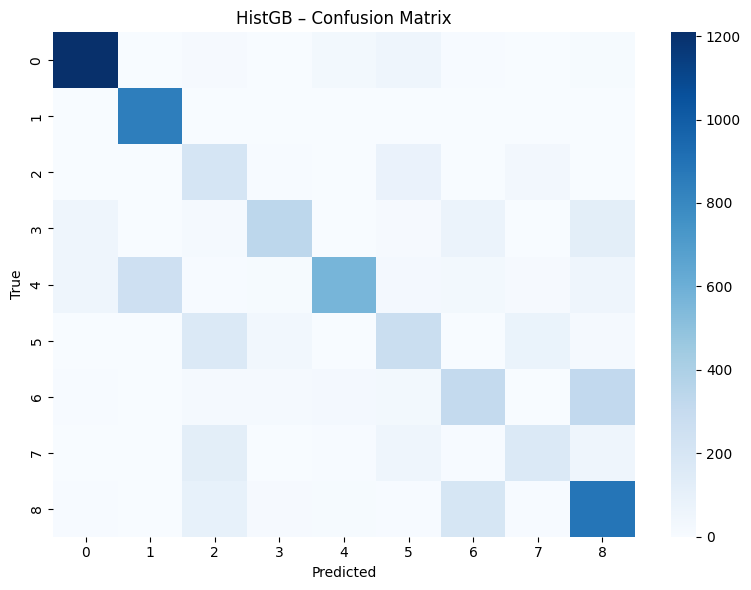

Model saved → pathmnist_histgb_grid.pkl


In [9]:
# ------------------------------------------------------------------
# Fast(er) boosting with GridSearchCV instead of RandomizedSearchCV
# ------------------------------------------------------------------
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt, joblib

hgb = HistGradientBoostingClassifier(
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=seed
)

param_grid = {
    "learning_rate":   [0.05, 0.07, 0.1],
    "max_depth":       [3, 4, 5],
    "max_iter":        [200, 300],      # boosting rounds
    "max_leaf_nodes":  [31, 63],        # fewer → faster
}

grid = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    cv=3,                  # 3-fold stratified CV
    scoring="accuracy",
    n_jobs=-1,             # use all CPU cores
    verbose=2
)

grid.fit(x_train_selected, y_train)
best_gb = grid.best_estimator_

print("⌾ Best params:", grid.best_params_)

# ----------------------  Evaluate on the hold-out test set  -------
y_pred = best_gb.predict(x_test_selected)
print("\n=== HistGradientBoosting (GridSearch) – Report ===")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Blues", annot=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("HistGB – Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# ----------------------  Persist for later use  -------------------
joblib.dump(best_gb, "pathmnist_histgb_grid.pkl")
print("Model saved → pathmnist_histgb_grid.pkl")

# To reload elsewhere:
# from joblib import load
# best_gb = load("pathmnist_histgb_grid.pkl")
# preds = best_gb.predict(new_X_selected)
